In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict,GridSearchCV
from sklearn.metrics import roc_auc_score,balanced_accuracy_score

In [77]:
#! pip install umap-learn

#### Display options

In [38]:
pd.set_option('display.max_row', 25)
pd.set_option('display.max_column', 25)

## First approach (just concatenate the prediction on the left and on the right side)

#### Load the prediction of presence of the PCS on the left hemisphere (HCP dataset)

In [39]:
HCP_binary_pred_left_PCS = pd.read_csv('/neurospin/dico/adufournet/Runs/04_Heritability_Left_PCS_HCP/Heritability/data/HCP_binary_pred_left_PCS.csv')
HCP_binary_pred_left_PCS

,IID,Pred
0,100206,0
1,100307,1
2,100408,1
3,100610,0
4,101006,0
...,...,...
1109,992774,0
1110,993675,1
1111,994273,0
1112,995174,1


#### Load the prediction of presence of the PCS on the right hemisphere (HCP dataset)

In [40]:
HCP_binary_pred_right_PCS = pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Heritability/data/HCP_binary_pred_PCS.csv")

#### Compute the asymmetry

In [299]:
HCP_asymmetry_PCS = abs(HCP_binary_pred_left_PCS.Pred - HCP_binary_pred_right_PCS.Pred)
HCP_asymmetry_PCS = pd.concat([HCP_binary_pred_left_PCS['IID'],HCP_asymmetry_PCS], axis=1)
HCP_asymmetry_PCS

,IID,Pred
0,100206,1
1,100307,0
2,100408,1
3,100610,0
4,101006,0
...,...,...
1109,992774,1
1110,993675,1
1111,994273,0
1112,995174,0


#### Save the asymmetry prediction on neurospin

In [42]:
HCP_asymmetry_PCS.to_csv("/neurospin/dico/adufournet/Runs/05_Heritability_Asymmetry_PCS_HCP/Heritability/data/HCP_asymmetry_PCS.csv", index=False)

## Second approach (Concatenate the right and left latent spaces, predict the asymmetry from it)

##### Load the embeddings representations for the ACCP (which is the training dataset) and the HCP dataset (which will be the input for the trained SVM classifier)

In [43]:
embeddings_ACCP_left= pd.read_csv("/neurospin/dico/adufournet/Runs/04_Heritability_Left_PCS_HCP/Program/Output/2024-05-13/09-33-29_206/acc_epoch60_embeddings/full_embeddings.csv")#, index_col=0)
embeddings_ACCP_right= pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Input/ACCpatterns_cingulate_full_embeddings.csv")
embeddings_ACCP = pd.concat([embeddings_ACCP_left,embeddings_ACCP_right.drop('ID', axis=1)], axis=1)
embeddings_ACCP

,ID,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
0,1-03HUBJO_t0,-10.300048,-8.993956,-24.014177,-22.748718,-20.079226,10.081562,-35.838430,-5.443741,-0.482752,11.556986,-8.657738,...,2.882060,-24.831553,-9.197613,-5.711463,-2.754603,-14.768034,17.421337,-33.757954,-2.704032,6.627081,-0.086178,23.621847
1,1-08ANDTI_t0,17.782938,-21.937262,-25.368660,5.567630,-42.060616,16.843365,12.600588,-10.436407,5.698798,8.553762,-15.713575,...,-2.165201,-25.279970,19.806355,-18.962173,15.065896,12.606016,10.264750,-11.282650,-15.794517,-1.264829,-1.585922,13.012749
2,1-11LEBJO_t0,-36.685577,5.157880,2.363987,-22.430391,-11.315966,13.808375,-49.053246,22.700457,-8.459773,12.038797,10.005174,...,1.524285,13.583164,10.764001,-33.918860,24.169624,18.739822,12.445322,23.753778,-24.569492,28.203157,-35.001040,5.951211
3,1-15LEHMI_t0,-16.128769,14.951199,-14.732849,5.576864,-21.033754,-10.399233,-45.814720,-26.131533,-27.402475,28.106800,-20.567886,...,-3.302573,-19.355429,4.560497,-19.082740,2.385815,12.654943,15.073609,-8.142779,-35.249516,-6.564681,-18.242151,-6.322456
4,1-17COLMA_t0,-12.741240,-20.531580,-7.063102,15.749422,-26.560053,2.146704,-26.149153,9.108587,-27.432632,32.134678,-5.934505,...,-2.317983,-25.239199,12.845156,11.860508,-7.861401,-8.461282,-8.631458,-9.310070,-5.761762,-24.695215,3.482464,-27.098180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,sub-inhibition25_ses-pretraining_T1w,-46.927147,-1.012615,39.200928,1.790302,-8.091936,22.930313,-56.579040,-5.073290,5.894837,17.353119,22.214405,...,-13.238676,4.240377,-47.951683,-5.288082,-19.935062,-10.275241,2.072381,-1.254634,-17.392796,22.209047,-30.299700,8.921869
337,sub-inhibition26_ses-pretraining_T1w,-31.228481,4.233710,10.857832,9.516086,0.792597,-30.693531,29.924980,26.852715,28.574594,8.175515,8.701328,...,-3.497534,1.546935,4.920863,-18.125204,1.087955,25.540407,19.166320,2.615173,-22.028465,16.422207,-15.004441,-15.991891
338,sub-inhibition28_ses-pretraining_T1w,-9.259340,10.269464,-4.369337,11.152019,-2.214729,-15.954047,18.052050,-21.549326,9.965367,5.791976,-1.654170,...,-19.229967,-5.518608,-7.411876,-5.617465,8.482850,12.970094,4.825340,7.096434,-18.960564,32.096100,-16.318506,-4.181726
339,sub-inhibition29_ses-pretraining_T1w,0.172009,-14.655333,-21.127450,8.332311,-21.689453,15.461191,-2.140106,-1.453473,18.745277,20.302645,25.477022,...,-31.701206,-5.535340,12.420484,-15.854844,-0.468121,15.632000,4.523982,20.061520,-1.616202,3.718000,-5.929497,2.169901


In [44]:
labels_ACCP = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv")
labels_ACCP = labels_ACCP[['long_name','Left_PCS', 'Right_PCS']]

In [45]:
def encoder(df, columns):
    for col in columns:
        code = {'present':1,
                'absent':0}
        df[col] = df[col].map(code)
    return df

encoder(labels_ACCP, ['Left_PCS', 'Right_PCS']) 

,long_name,Left_PCS,Right_PCS
0,nih_chp_04701_t1,1,0
1,nih_chp_01534_t1,1,1
2,nih_chp_04623_t1,1,1
3,nih_chp_01503_t1,0,0
4,nih_chp_00404_t1,1,1
...,...,...,...
376,a0005_t1_s03,0,1
377,a0006_t1_s03,1,0
378,a0001_t1_s03,1,1
379,a0016_t1_s03,0,1


In [46]:
labels_ACCP['Asymmetry'] = abs(labels_ACCP.Left_PCS - labels_ACCP.Right_PCS)
labels_ACCP

,long_name,Left_PCS,Right_PCS,Asymmetry
0,nih_chp_04701_t1,1,0,1
1,nih_chp_01534_t1,1,1,0
2,nih_chp_04623_t1,1,1,0
3,nih_chp_01503_t1,0,0,0
4,nih_chp_00404_t1,1,1,0
...,...,...,...,...
376,a0005_t1_s03,0,1,1
377,a0006_t1_s03,1,0,1
378,a0001_t1_s03,1,1,0
379,a0016_t1_s03,0,1,1


In [47]:
embeddings_HCP_left = pd.read_csv("/neurospin/dico/adufournet/Runs/04_Heritability_Left_PCS_HCP/Program/Output/2024-05-13/09-33-29_206/hcp_epoch60_embeddings/full_embeddings.csv", index_col=0)
embeddings_HCP_right = pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Input/hcp_cingulate_full_embeddings.csv", index_col=0)
embeddings_HCP = pd.concat([embeddings_HCP_left,embeddings_HCP_right], axis=1)
embeddings_HCP

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,,,,,
100206,-5.876003,-0.845744,-12.204170,10.151408,-18.957836,-29.795780,12.937123,-7.214358,15.110987,10.792451,-7.787244,9.263735,...,15.884296,-10.469205,0.255839,-26.942001,9.252998,9.163906,6.532629,10.676800,-14.139249,0.045611,-35.327550,-13.927697
100307,-19.529308,-7.768003,-16.622694,15.692203,-32.981106,-20.219995,-20.074820,3.648118,4.962884,28.067015,7.735142,13.419550,...,14.628305,-5.092073,6.490175,-8.862627,13.441197,2.842024,6.585532,25.127434,-6.861317,15.825949,-23.992393,-9.157214
100408,-24.607979,2.905064,-9.724290,35.772090,-38.557724,5.821410,-11.363668,18.840570,-9.526131,34.880870,-6.178275,-7.339914,...,22.036820,4.887552,28.514357,-9.187751,-13.514122,-2.253131,2.700759,7.052255,-21.251228,-8.701427,-5.803285,-24.713255
100610,-8.027011,0.322856,-15.113009,3.927100,-22.753002,-6.738647,10.846553,47.801365,18.840824,19.917740,-4.696721,-15.373317,...,-12.174725,-18.633965,-14.625642,-21.709137,7.999446,23.296196,2.751116,-6.180230,-41.432198,0.679659,-29.611362,-17.983616
101006,-25.976790,-5.441645,-10.610805,-9.526792,14.037749,-4.063296,12.062643,-15.676752,12.239485,5.389635,8.132303,-29.955600,...,-15.340488,-10.146723,-17.744781,12.339481,5.968554,16.571490,7.573746,-6.312110,-21.530790,18.567806,-16.335620,3.381026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992774,17.165743,-36.441390,-22.935884,-14.686571,-9.867681,-7.135174,26.120441,-12.414014,16.909752,-9.952538,-22.462795,-1.405541,...,-6.833909,16.613867,2.221115,-4.456804,-3.220039,8.444373,4.747440,21.607277,-8.192159,10.038024,-6.542052,9.730474
993675,-37.006813,28.016909,8.215394,-3.528147,10.978013,-11.092725,-10.434095,10.676113,-4.587836,-6.940797,-5.100392,5.050050,...,-20.458132,-20.188393,-8.345625,-4.067662,-9.169641,-1.396057,6.299828,0.995704,-13.701394,-9.113794,-8.200265,-12.685424
994273,-35.012260,7.191190,18.193295,-24.775734,10.159574,-2.134576,-51.921300,11.000490,4.337312,6.170895,22.973560,0.902636,...,-3.469933,-11.665941,-10.113407,-2.895253,9.940379,15.714289,13.029745,-6.024564,-18.540964,5.411079,-20.089376,-16.943203


#### Scaler

In [168]:
ebdd_lbl_ACCP = embeddings_ACCP.set_index('ID').join(labels_ACCP.set_index('long_name'))
X = ebdd_lbl_ACCP.drop(['Asymmetry','Left_PCS','Right_PCS'], axis=1)
y = ebdd_lbl_ACCP['Right_PCS']

The scaler is fited on the ACCP database at first, it transforms it and then transforms the HCP dataset.
Is it better to fit one everything and transform everything at once ?

In [169]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
scl_bdd_hcp = scaler.transform(embeddings_HCP)
X.shape ,scl_bdd_hcp.shape, y.shape

((341, 512), (1114, 512), (341,))

#### SVC model, training on the ACCP database

In [176]:
parameters = {'kernel':('linear', 'rbf', 'poly'),'C' : [0.0001, 0.001, 0.01,0.1,1,10,100,1000], 'degree': [1,2,3]}
svc = SVC(class_weight='balanced')
clf = GridSearchCV(svc, parameters, cv=5,)
clf.fit(X, y)

GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3],
                         'kernel': ('linear', 'rbf', 'poly')})

In [177]:
clf.best_estimator_

SVC(C=1, class_weight='balanced', degree=1)

In [263]:
from sklearn.neural_network import MLPClassifier

parameters = {'alpha': [1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000], 
              'hidden_layer_sizes': [(100), (50), (10,10), (5,5), (100,5)]}
mlp = MLPClassifier(activation='relu')
clf = GridSearchCV(mlp, parameters, cv=5,)
clf.fit(X, y)

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Opti

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000],
                         'hidden_layer_sizes': [100, 50, (10, 10), (5, 5),
                                                (100, 5)]})

In [264]:
clf.best_estimator_

MLPClassifier(alpha=10, hidden_layer_sizes=50)

In [255]:
#from train_multiple_classifiers import train_classifiers,train_one_classifier
model = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

In [265]:
model = MLPClassifier(alpha=10, hidden_layer_sizes=50,activation='relu')

In [266]:
outputs = {}
val_pred = cross_val_predict(model, X, y, cv=5)
auc = roc_auc_score(y, val_pred)
outputs['labels_pred'] = val_pred
outputs['auc'] = auc
outputs['balanced_accuracy_score'] = balanced_accuracy_score(y, val_pred)

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [267]:
outputs['auc'], outputs['balanced_accuracy_score']

(0.7473032994923857, 0.7473032994923858)

La valeur d'auc ci dessous n'est pas fiable car on s'entraîne sur l'ensemble du modèle pour tester sur l'ensemble du modèle.

In [268]:
model.fit(X,y)
roc_auc_score(y,model.predict_proba(X)[:,1]), balanced_accuracy_score(y, model.predict(X))

/usr/lib/python3/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.9998589960518894, 0.9930555555555556)

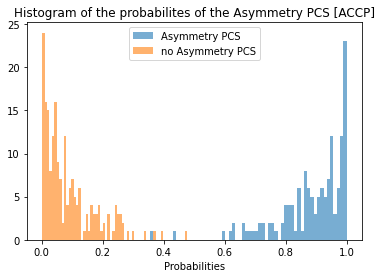

In [269]:
plt.hist(model.predict_proba(X)[y==1,1], bins=60, alpha=0.6, label='Asymmetry PCS')
plt.hist(model.predict_proba(X)[y==0,1], bins=60, alpha=0.6, label='no Asymmetry PCS')
plt.xlabel('Probabilities')
plt.title('Histogram of the probabilites of the Asymmetry PCS [ACCP]')
plt.legend()
plt.show()

In [270]:
float((model.predict(X) == (model.predict_proba(X)>0.5)[:,1]).sum())/len(X)

1.0

#### Classification of the HCP embeddings

In [271]:
val_pred = model.predict(X=scl_bdd_hcp)

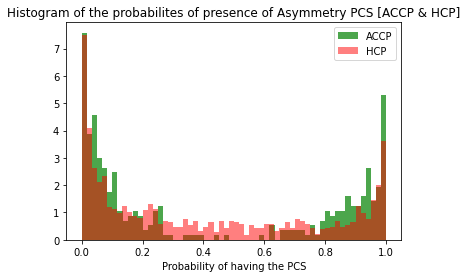

In [272]:
plt.hist(model.predict_proba(X)[:,1], bins=60, color='g', alpha=0.7, label='ACCP', density=True)
plt.hist(model.predict_proba(scl_bdd_hcp)[:,1], bins=60, color='red', alpha=0.5, label='HCP', density=True)
plt.xlabel('Probability of having the PCS')
plt.title('Histogram of the probabilites of presence of Asymmetry PCS [ACCP & HCP]')
plt.legend()
plt.show()

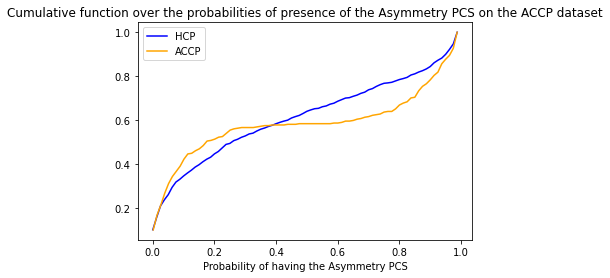

In [274]:
values_ACCP, base_ACCP = np.histogram(model.predict_proba(X)[:,1], bins=80)
cumulative_ACCP = np.cumsum(values_ACCP)
values_HCP, base_HCP = np.histogram(model.predict_proba(scl_bdd_hcp)[:,1], bins=80)
cumulative_HCP = np.cumsum(values_HCP)
# plot the cumulative function
plt.plot(base_HCP[:-1], cumulative_HCP/len(scl_bdd_hcp), c='blue', label='HCP')
#plot the survival function
#plt.plot(base_HCP[:-1], len(model.predict_proba(scl_bdd_hcp)[:,1])-cumulative_HCP, c='green', label = 'survival function')
plt.xlabel('Probability of having the Asymmetry PCS')
plt.legend()
plt.title('Cumulative function over the probabilities of presence of the Asymmetry PCS on the HCP dataset')

# plot the cumulative function
plt.plot(base_ACCP[:-1], cumulative_ACCP/len(X), c='orange', label='ACCP')
#plot the survival function
#plt.plot(base_ACCP[:-1], len(model.predict_proba(X)[:,1])-cumulative_ACCP, c='red', label = 'survival function')
plt.xlabel('Probability of having the Asymmetry PCS')
plt.legend()
plt.title('Cumulative function over the probabilities of presence of the Asymmetry PCS on the ACCP dataset')
plt.show()

#### SVM classification between ACCP and HCP datasets

In [275]:
scd_bdd_hcp = pd.DataFrame(scl_bdd_hcp, columns=embeddings_HCP.columns)
scd_bdd_hcp['Dataset'] = 0

scd_bdd_ACCP = pd.DataFrame(X,columns=embeddings_HCP.columns)
scd_bdd_ACCP['Dataset'] = 1

In [276]:
scd_bdd_HCP_ACCP = pd.concat([scd_bdd_hcp,scd_bdd_ACCP], axis=0)
scd_bdd_HCP_ACCP

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256,Dataset
0,0.239927,-0.224921,-0.675947,0.759515,-0.956935,-1.686962,0.917758,-0.099048,0.551403,-0.450550,-0.690937,0.095653,...,-0.263852,-0.387313,-1.644946,1.037354,0.579531,-0.036738,0.223121,-0.565826,-0.630988,-2.621130,-0.653645,0
1,-0.611324,-0.706184,-0.937171,1.111977,-2.116829,-1.085650,-0.845706,0.497010,-0.167517,0.776780,0.422909,0.393078,...,0.302055,-0.008871,-0.024336,1.361399,0.078629,-0.031831,1.307759,-0.048032,0.645575,-1.590091,-0.305347,0
2,-0.927968,0.035850,-0.529336,2.389300,-2.578083,0.549624,-0.380365,1.330667,-1.193960,1.260893,-0.575481,-1.092644,...,1.352344,1.328060,-0.053479,-0.724158,-0.325076,-0.392211,-0.048931,-1.071814,-1.338587,0.064379,-1.441109,0
3,0.105817,-0.143676,-0.847918,0.363574,-1.270841,-0.239086,0.806082,2.919835,0.815635,0.197787,-0.469169,-1.667582,...,-1.123138,-1.290661,-1.175879,0.940366,1.699275,-0.387540,-1.042137,-2.507606,-0.579697,-2.101189,-0.949772,0
4,-1.013310,-0.544447,-0.581747,-0.492257,1.772198,-0.071087,0.871044,-0.563405,0.347977,-0.834411,0.451408,-2.711213,...,-0.229913,-1.480002,1.876193,0.783234,1.166456,0.059843,-1.052035,-1.091704,0.867379,-0.893636,0.610082,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,-2.319516,-0.236523,2.363126,0.227647,-0.058194,1.623980,-2.795725,0.018439,-0.101495,0.015575,1.461902,-0.605856,...,1.284233,-3.313647,0.296082,-1.220952,-0.960692,-0.450504,-0.672430,-0.797303,1.161940,-2.163800,1.014625,1
337,-1.340740,0.128223,0.687480,0.719101,0.676664,-1.743337,1.825232,1.770318,1.505202,-0.636479,0.492240,-2.154838,...,1.000766,-0.104133,-0.854621,0.405617,1.877090,1.135257,-0.381970,-1.127111,0.693809,-0.772553,-0.804354,1
338,0.028984,0.547852,-0.212751,0.823166,0.427922,-0.817769,1.190992,-0.885652,0.186872,-0.805826,-0.250844,0.707851,...,0.257165,-0.852765,0.266556,0.977767,0.881106,-0.195119,-0.045615,-0.908843,1.961761,-0.892079,0.057918,1
339,0.617007,-1.185019,-1.203492,0.643798,-1.182873,1.154955,0.112348,0.217070,0.808866,0.225134,1.696019,-0.561314,...,0.255404,0.351116,-0.651109,0.285222,1.092017,-0.223076,0.927521,0.325137,-0.333908,0.052898,0.521657,1


In [277]:
from sklearn.model_selection import train_test_split

In [278]:
X_train, X_test, y_train, y_test = train_test_split(scd_bdd_HCP_ACCP.drop("Dataset", axis=1), scd_bdd_HCP_ACCP["Dataset"], test_size=0.01, random_state=40)

In [279]:
model2 = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

In [280]:
model2.fit(X_train,y_train)
val_predict = cross_val_predict(model2, X_train, y_train, cv=10)
auc = roc_auc_score(y_train, val_predict)
auc

0.8012757222681062

In [281]:
roc_auc_score(y_test, model2.predict_proba(X_test)[:,1])

0.9772727272727273

### Visualization (UMAP)

In [282]:
import umap

In [283]:
reducer = umap.UMAP()#random_state=5)
scd_bdd_ACCP['Asymmetry'] = y.values
scd_bdd_ACCP['Dataset'] = 'ACCP'
scd_bdd_ACCP['Prediction'] = model.predict(X)
scd_bdd_hcp['Asymmetry'] = -1
scd_bdd_hcp['Dataset'] = 'HCP'
scd_bdd_hcp['Prediction'] = model.predict(scl_bdd_hcp)

We fit the reducer only on the ACCP database, we concatenate then the two bases and we reduce the m together.

In [284]:
reducer.fit(scd_bdd_ACCP.drop(['Asymmetry','Dataset','Prediction'], axis=1))
HCP_and_ACCP = pd.concat([scd_bdd_hcp, scd_bdd_ACCP], axis=0)
embedding2D_HCP_and_ACCP = reducer.transform(HCP_and_ACCP.drop(['Asymmetry','Dataset','Prediction'], axis=1))

The first figure is made to observe the site effect between ACCP and HCP databases.

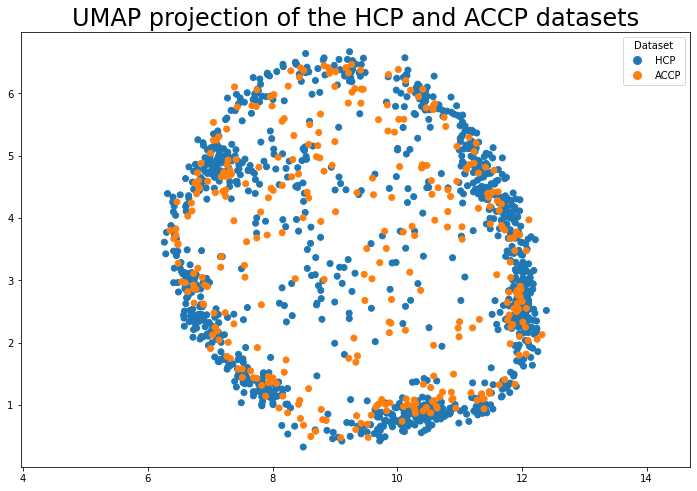

In [285]:
dataset_colors = [sns.color_palette()[0] if x == 'HCP' else sns.color_palette()[1] for x in HCP_and_ACCP['Dataset']]

plt.figure(figsize=(12, 8))
plt.scatter(
    embedding2D_HCP_and_ACCP[:, 0],
    embedding2D_HCP_and_ACCP[:, 1],
    c=dataset_colors)
plt.gca().set_aspect('equal', 'datalim')
unique_values = HCP_and_ACCP['Dataset'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=sns.color_palette()[i], markersize=10, 
                              label=f'{unique_values[i]}') 
                  for i in range(len(unique_values))]

plt.title('UMAP projection of the HCP and ACCP datasets', fontsize=24)
plt.legend(handles=legend_handles, title='Dataset', loc='best')
plt.show()

The second figure is made to point out the position of the people having the paracingular (1) (from the ACCP database), those who don't have it (0) (from the ACCP database), and those we don't know (-1) (from the HCP database).

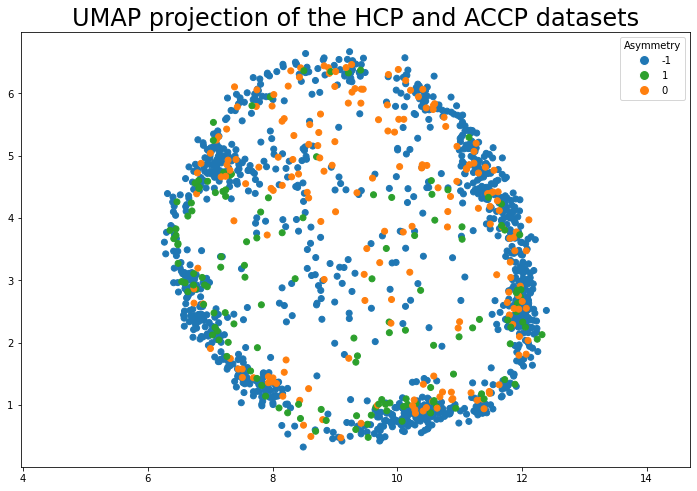

In [286]:
def plot_UMAP(ebb2D_dataset, initial_dataset, title, hue, coli=1):
    plt.figure(figsize=(12,8))
    plt.scatter(
        ebb2D_dataset[:, 0],
        ebb2D_dataset[:, 1],
        c=[sns.color_palette()[x+coli] for x in initial_dataset[hue]])
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=24)
    unique_values = initial_dataset[hue].unique()
    colors = [sns.color_palette()[x+coli] for x in unique_values]
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=colors[i], markersize=10, 
                                label=f'{unique_values[i]}') 
                    for i in range(len(unique_values))]
    plt.legend(handles=legend_handles, title=hue, loc='best')
    plt.show()

plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', 'Asymmetry')

Then, the following figure highlights the two classes in the ACCP database.

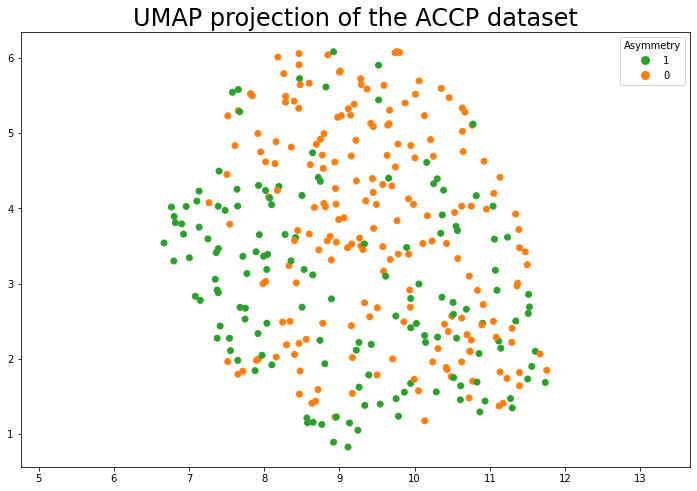

In [287]:
embedding2D_ACCP = reducer.transform(scd_bdd_ACCP.drop(['Asymmetry','Dataset','Prediction'], axis=1))

plot_UMAP(embedding2D_ACCP, scd_bdd_ACCP, 'UMAP projection of the ACCP dataset', 'Asymmetry')

We can do the same one by only keeping the 10 best ranked values given the SVM linear classification, on the ACCP database at first, and on the HCP then.

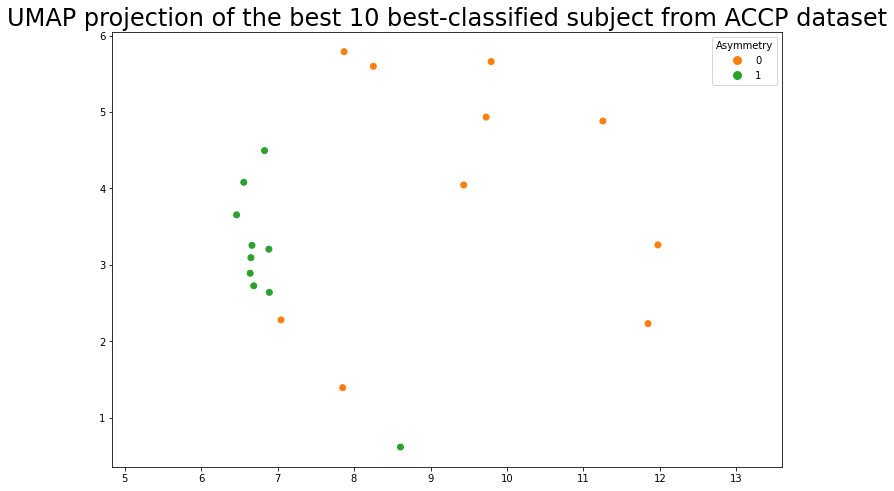

In [288]:
ACCP_proba_pred = model.predict_proba(X)
#ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[0:10]] # top 10 best ranked label 1
#ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[-10:]] # top 10 best ranked label 0
#scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]] # check if the prediction are also the ground truth (that's a yes)
#scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]] # check if the prediction are also the ground truth (that's a yes as well)
best_ACCP = pd.concat([scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]],scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]]], axis=0)
embedding2D_best_classified_ACCP = reducer.transform(best_ACCP.drop(['Asymmetry','Dataset','Prediction'], axis=1))
plot_UMAP(embedding2D_best_classified_ACCP, best_ACCP, 'UMAP projection of the best 10 best-classified subject from ACCP dataset', 'Asymmetry')


Let's see the SVC borders on the UMAP

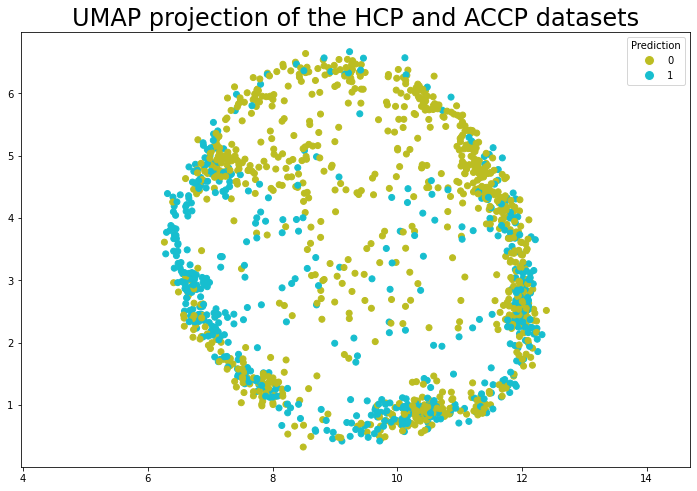

In [289]:
plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', 'Prediction',-2)

We can get the ID of the best classified subject and see in the Anatomist if the paracingular is there or not.

In [298]:
ACCP_proba_pred = model.predict_proba(scd_bdd_hcp.drop(['Asymmetry', 'Dataset', 'Prediction'], axis=1))
ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[0:5]]

array([[2.60190032e-04, 9.99739810e-01],
       [3.88094758e-04, 9.99611905e-01],
       [4.53674007e-04, 9.99546326e-01],
       [5.08333691e-04, 9.99491666e-01],
       [5.77494310e-04, 9.99422506e-01]])

In [291]:
ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[-5:]]

array([[9.99394945e-01, 6.05055008e-04],
       [9.99455398e-01, 5.44601732e-04],
       [9.99581362e-01, 4.18638092e-04],
       [9.99601291e-01, 3.98709265e-04],
       [9.99885175e-01, 1.14825392e-04]])

In [292]:
embeddings_HCP.iloc[ACCP_proba_pred[:,0].argsort()[1114//2-2:1114//2+2]].index

Int64Index([147030, 154330, 195849, 144125], dtype='int64', name='ID')

First 5 people predicted without paracingulate sulcus.

In [293]:
embeddings_HCP.iloc[ACCP_proba_pred[:,0].argsort()[-5:]].index

Int64Index([381543, 138231, 735148, 485757, 151930], dtype='int64', name='ID')

First 5 people predicted with paracingulate sulcus.

In [294]:
embeddings_HCP.iloc[ACCP_proba_pred[:,0].argsort()[0:5]].index

Int64Index([959574, 784565, 101309, 468050, 397861], dtype='int64', name='ID')

### CSV file generation for SOLAR

In [300]:
df_HCP_binary_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict(X=scl_bdd_hcp)})

df_HCP_binary_pred_PCS.to_csv('/neurospin/dico/adufournet/Runs/05_Heritability_Asymmetry_PCS_HCP/Heritability/data/512_pred_asymmetry_PCS.csv', index=False)
df_HCP_binary_pred_PCS.sort_values('IID')

,IID,Pred
0,100206,0
1,100307,1
2,100408,0
3,100610,0
4,101006,0
...,...,...
1109,992774,1
1110,993675,0
1111,994273,0
1112,995174,1


In [304]:
(HCP_asymmetry_PCS['Pred'] == df_HCP_binary_pred_PCS['Pred']).sum()/len(HCP_asymmetry_PCS)

0.42010771992818674

In [305]:
df_HCP_prob_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict_proba(scl_bdd_hcp)[:,1]})

df_HCP_prob_pred_PCS.to_csv('/neurospin/dico/adufournet/Runs/05_Heritability_Asymmetry_PCS_HCP/Heritability/data/512_pred_proba_asymmetry_PCS.csv', index=False)
df_HCP_prob_pred_PCS

,IID,Pred
0,100206,0.481343
1,100307,0.864546
2,100408,0.047435
3,100610,0.030913
4,101006,0.076478
...,...,...
1109,992774,0.701968
1110,993675,0.005147
1111,994273,0.033584
1112,995174,0.903750


In [297]:
'''df_HCP_prob_pred_without_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict_proba(scl_bdd_hcp)[:,0]})

df_HCP_prob_pred_without_PCS.to_csv('/neurospin/dico/adufournet/Runs/04_Heritability_Left_PCS_HCP/Heritability/data/HCP_prob_pred_without_left_PCS.csv', index=False)
df_HCP_prob_pred_without_PCS'''

'df_HCP_prob_pred_without_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),\n              "Pred" : model.predict_proba(scl_bdd_hcp)[:,0]})\n\ndf_HCP_prob_pred_without_PCS.to_csv(\'/neurospin/dico/adufournet/Runs/04_Heritability_Left_PCS_HCP/Heritability/data/HCP_prob_pred_without_left_PCS.csv\', index=False)\ndf_HCP_prob_pred_without_PCS'